The goal of this script is to apply a nn model to signal event data to investigate whether the model assigns the highest scores to the b pairs that  reconstruct to the Higgs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward
from keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler
from pickle import load
# from sixB_event import sixB_event

Using TensorFlow backend.


In [2]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10, 7)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Step One: Load model and Input Scaler

In [6]:
filepath = '/eos/user/s/srosenzw/SWAN_projects/sixB/Machine_Learning/NN_models/'

# load json and create model
json_file = open(filepath + 'higgs_pair_classifier_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(filepath + "higgs_pair_classifier_1.h5")
scaler = load(open(filepath + 'scaler.pkl', 'rb'))
print("Loaded model and scaler from disk")

W0122 14:28:30.706149 140243284686656 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0122 14:28:30.759105 140243284686656 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0122 14:28:30.800872 140243284686656 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3217: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as

Loaded model and scaler from disk


# Step Two: Import signal events

In [7]:
MX = 700
MY = 400

In [8]:
filename = '/eos/user/s/srosenzw/SWAN_projects/sixB/Signal_Exploration/Mass_Pair_ROOT_files/X_YH_HHH_6b_MX' + str(MX) + '_MY' + str(MY) + '.root'

In [9]:
f = uproot.open(filename)
tree = f['sixbntuplizer/sixBtree']
branches = tree.arrays(namedecode='utf-8')
table = awkward.Table(branches)
nevents = len(table['gen_HX_b1_pt'])

In [10]:
HX_b1 = {'pt':table['gen_HX_b1_pt'], 'eta':table['gen_HX_b1_eta'], 'phi':table['gen_HX_b1_phi'], 'm':table['gen_HX_b1_m']}
HX_b2 = {'pt':table['gen_HX_b2_pt'], 'eta':table['gen_HX_b2_eta'], 'phi':table['gen_HX_b2_phi'], 'm':table['gen_HX_b2_m']}
HY1_b1 = {'pt':table['gen_HY1_b1_pt'], 'eta':table['gen_HY1_b1_eta'], 'phi':table['gen_HY1_b1_phi'], 'm':table['gen_HY1_b1_m']}
HY1_b2 = {'pt':table['gen_HY1_b2_pt'], 'eta':table['gen_HY1_b2_eta'], 'phi':table['gen_HY1_b2_phi'], 'm':table['gen_HY1_b2_m']}
HY2_b1 = {'pt':table['gen_HY2_b1_pt'], 'eta':table['gen_HY2_b1_eta'], 'phi':table['gen_HY2_b1_phi'], 'm':table['gen_HY2_b1_m']}
HY2_b2 = {'pt':table['gen_HY2_b2_pt'], 'eta':table['gen_HY2_b2_eta'], 'phi':table['gen_HY2_b2_phi'], 'm':table['gen_HY2_b2_m']}
part_dict = {0:HX_b1, 1:HX_b2, 2:HY1_b1, 3:HY1_b2, 4:HY2_b1, 5:HY2_b2}
pair_dict = {0:1, 1:0, 2:3, 3:2, 4:5, 5:4} # Used later to verify that non-Higgs pair candidates are truly non-Higgs pairs
part_id = {0:'HX_b1', 1:'HX_b2', 2:'HY1_b1', 3:'HY1_b2', 4:'HY2_b1', 5:'HY2_b2'}

In [11]:
pair_id = {}
ii = 0

for i in range(5):
    for j in range(i+1,6):
        pair_id[ii] = part_id[i]+' & '+part_id[j]
        ii+=1

# Step Three: Obtain nn score for each pairing

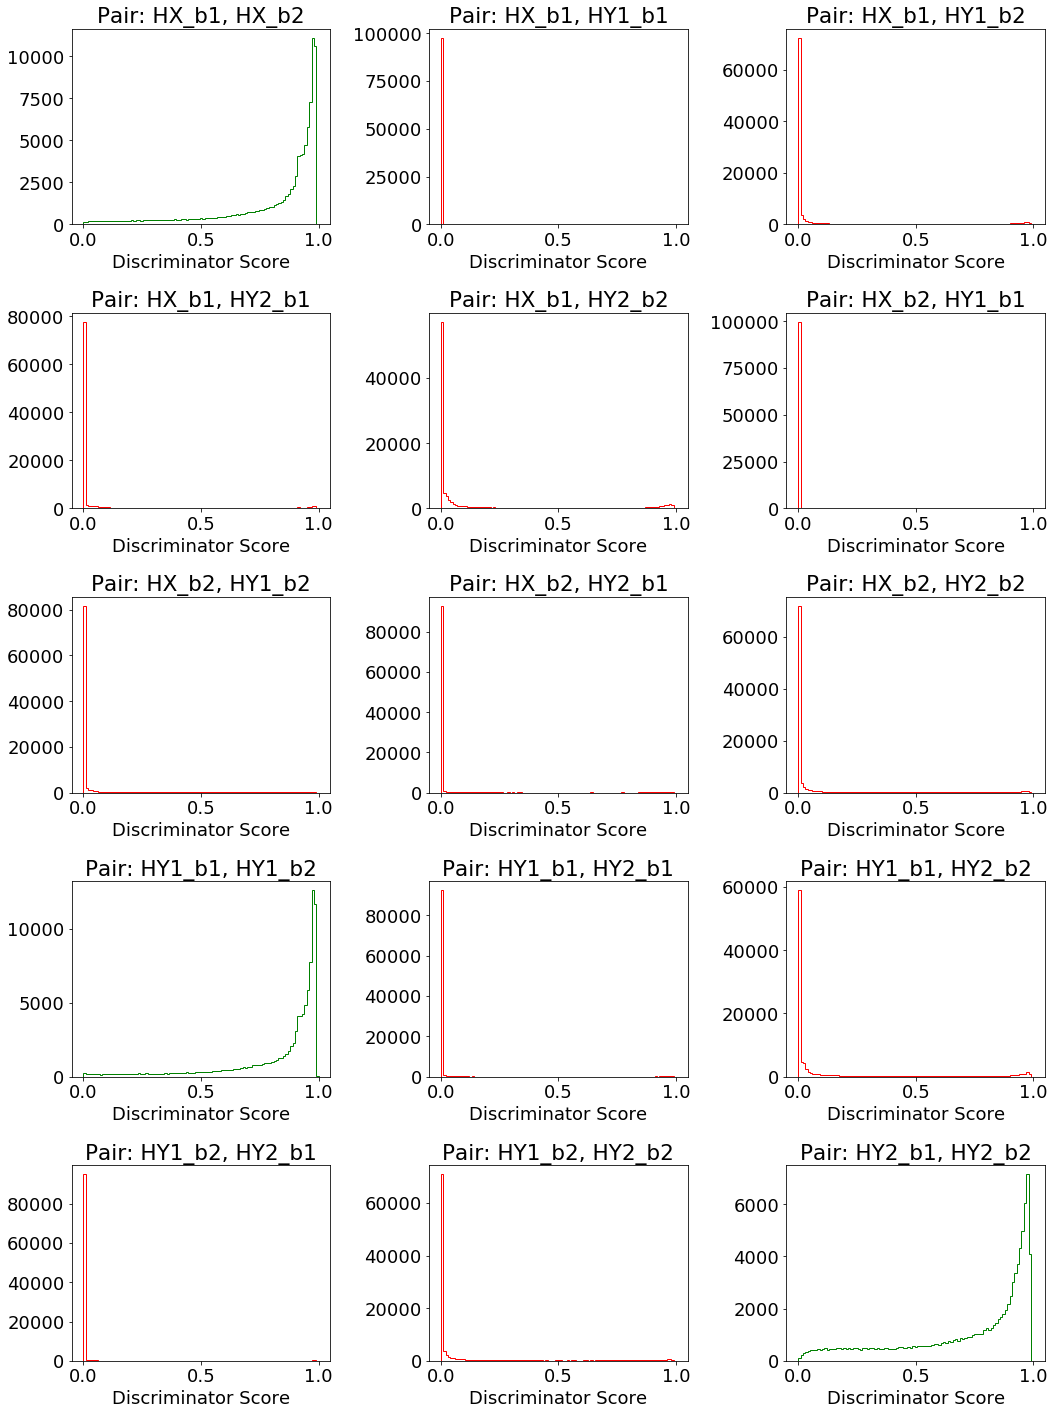

In [12]:
predictions = np.array(())
inputs = np.array(())
count = 0
flag = True
fig, axs = plt.subplots(nrows=5,ncols=3,figsize=(15,20))

for i in range(5):
    for j in range(i+1,6):
        inputs = np.transpose(np.vstack( 
                         (part_dict[i]['pt'], part_dict[i]['eta'], part_dict[i]['phi'], 
                          part_dict[j]['pt'], part_dict[j]['eta'], part_dict[j]['phi'], 
                          part_dict[i]['pt']*part_dict[j]['pt']) ))
        
        xnormalized = scaler.transform(inputs)
        evt_pred = np.ravel(loaded_model.predict(xnormalized))
        predictions = np.append(predictions, evt_pred)
        
        ax = axs[count//3][count%3]
        
        ax.set_title("Pair: {}, {}".format(part_id[i],part_id[j]))
        if (i == 0 and j == 1) or (i == 2 and j == 3) or (i == 4 and j == 5):
            color = 'green'
        else:
            color = 'red'
        ax.hist(evt_pred, bins=np.linspace(0,1,100), histtype='step', align='mid', color=color)
        ax.set_xlabel('Discriminator Score')
        
        count+=1
        
plt.tight_layout()

fig.savefig("signal_event_class_dist.pdf")

In [13]:
predictions = predictions.reshape(15,100000)

In [14]:
predictions = np.transpose(predictions)

In [15]:
max_inds = np.argsort(predictions, axis=1)

In [38]:
three_highest = max_inds[:,-4:-1]

In [59]:
all_Higgs_are_top_three = 0
two_Higgs_are_top_three = 0
one_Higgs_are_top_three = 0
for row in three_highest:
    if (0 in row) and (9 in row) and (14 in row):
        all_Higgs_are_top_three += 1
    if (0 in row and 9 in row) or (0 in row and 14 in row) or (9 in row and 14 in row):
        two_Higgs_are_top_three += 1
    if (0 in row) or (9 in row) or (14 in row):
        one_Higgs_are_top_three += 1

In [101]:
print(f"Percentage of signal events with highest score designated to all \
three Higgs pairs: {all_Higgs_are_top_three/nevents*100:.2f}%")

Percentage of signal events with highest score designated to all three Higgs pairs: 8.37%


In [102]:
print(f"Percentage of signal events with highest score designated to two of the \
three Higgs pairs: {two_Higgs_are_top_three/nevents*100:.2f}%")

Percentage of signal events with highest score designated to two of the three Higgs pairs: 87.64%


In [103]:
print(f"Percentage of signal events with highest score designated to one of the \
three Higgs pairs: {one_Higgs_are_top_three/nevents*100:.2f}%")

Percentage of signal events with highest score designated to one of the three Higgs pairs: 99.54%


In [16]:
ticks = [pair_id[jj] for jj in np.arange(0,15)]

rate_bins = np.arange(0,16)
n_highest, edges = np.histogram(max_inds[:,-1], bins=rate_bins)
n_sec_highest, edges = np.histogram(max_inds[:,-2], bins=rate_bins)
n_th_highest, edges = np.histogram(max_inds[:,-3], bins=rate_bins)

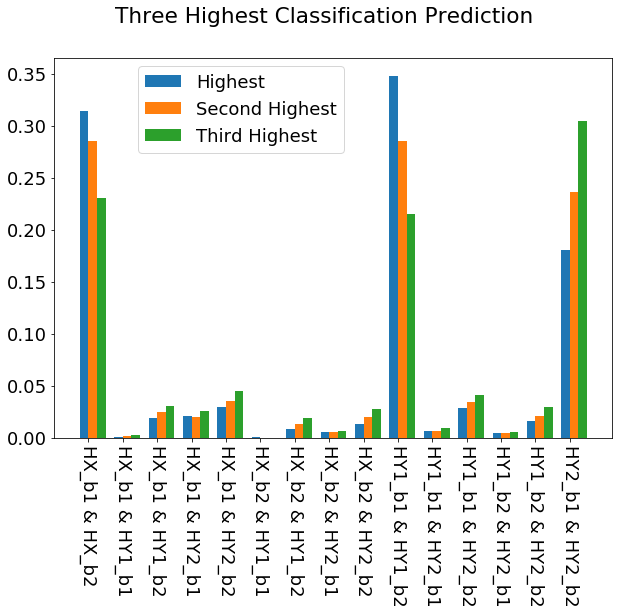

In [17]:
x_ticks = np.arange(0,15)
width = 0.25

fig, ax = plt.subplots()
fig.suptitle('Three Highest Classification Prediction')
ax.bar(x_ticks, n_highest/nevents, width=width, label='Highest')
ax.bar(x_ticks + width, n_sec_highest/nevents, width=width, label='Second Highest')
ax.bar(x_ticks + 2*width, n_th_highest/nevents, width=width, label='Third Highest')
ax.set_xticks(x_ticks + width / 2)
ax.set_xticklabels(ticks)
ax.tick_params(axis='x', rotation=270)
ax.legend(loc=[0.15,0.75])

In [18]:
HX_ratings = (max_inds == 0).sum(axis=0)/nevents
HY1_ratings = (max_inds == 9).sum(axis=0)/nevents
HY2_ratings = (max_inds == 14).sum(axis=0)/nevents

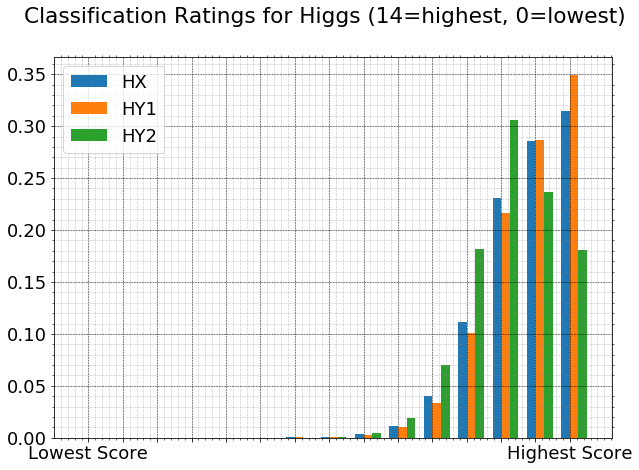

In [27]:
fig, ax = plt.subplots()
fig.suptitle('Classification Ratings for Higgs (14=highest, 0=lowest)')
ax.bar(x_ticks, HX_ratings, width=width, label='HX')
ax.bar(x_ticks + width, HY1_ratings, width=width, label='HY1')
ax.bar(x_ticks + 2*width, HY2_ratings, width=width, label='HY2')
ax.set_xticks(x_ticks + width / 2)
ax.set_xticklabels(['Lowest Score'] + ['']*13 + ['Highest Score'])
ax.minorticks_on()
ax.tick_params(which='minor', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='off') # turn off bottom ticks
ax.grid(which='major', linestyle='--', linewidth='0.5', color='black')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
# ax.set_xlabel("")

ax.legend()
